# Corona prepping using Finnish data regression using a categorical boosting forest algorithm

## Main question: at this point we're interested in one single classification, i.e. __what predicts whether people do maskless contacts with non-householders__

[Research Document](https://docs.google.com/document/d/1iLciHcvVvf8QwFS7wiyNBevpD1B9yDRqMlM4_oCcVcA/edit?usp=sharing)

[Questions codebook](https://docs.google.com/document/d/1YZVCP1UNxnNLAK2kYDfA9Y98leTZYurZD-d8iByhdi0/edit?usp=sharing)

[Method of delivery](https://docs.google.com/document/d/1G1JT9JUJrTK3aaXXuRawYACJaGNxU7mcXL9i-d8eKXY/edit)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# import session_info

from ml_class import (plot_cv_indices,
                      plot_decision_boundary,
                     plot_learning_curve,
                     multi_roc_auc_plot,
                     dict_of_models,
                     RFE_opt_rf,
                     make_confusion_matrix,
                     summary_performance_metrics_classification)

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, GroupKFold, GroupShuffleSplit, RepeatedStratifiedKFold, RepeatedKFold
# from sklearn.impute import IterativeImputer

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.feature_selection import RFE, RFECV

In [3]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_validate
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from imblearn.ensemble import BalancedBaggingClassifier

In [4]:
from sklearn.model_selection import KFold

In [5]:
# from sklearn import tree
# import graphviz

In [6]:
# import xgboost
import shap
shap.initjs()

In [8]:
# _ = sns.set_style("whitegrid")

### Virtual Environments and Packages

In [9]:
# session_info.show(req_file_name="corona_preppers-requirements.txt",
#       write_req_file=False) #add write_req_file=True to function to get requirements.txt file of packages used

### Read in data, show info and data head

In [10]:
df = pd.read_csv("data/shield_gjames_21-09-20_prepped.csv").drop("Unnamed: 0", axis=1)

In [11]:
df.head()

,id,sampling_weight,demographic_gender,demographic_age,demographic_4_areas,demographic_8_areas,demographic_higher_education,behaviour_indoors_nonhouseholders,behaviour_close_contact,behaviour_quarantined,...,intention_public_transport_recoded,intention_indoor_meeting_recoded,intention_restaurant_recoded,intention_pa_recoded,intention_composite,behaviour_indoors_nonhouseholders_recoded,behaviour_unmasked_recoded,behavior_composite,behavior_composite_recoded,intention_behavior_composite
0,1,2.060959,2,60+,2,7,0,2,5,2,...,0,0,0,0,0,1.000000,0.000000,0.000000,0.000000,0.000000
1,2,1.784139,2,40-49,1,1,1,3,3,2,...,0,1,1,1,3,0.785714,0.214286,0.168367,0.841837,1.920918
2,3,1.204000,1,60+,1,2,1,4,4,2,...,0,0,0,0,0,0.500000,0.214286,0.107143,0.535714,0.267857
3,4,2.232220,1,60+,2,6,0,4,3,2,...,0,2,0,2,4,0.500000,0.500000,0.250000,1.250000,2.625000
4,5,1.627940,2,18-29,1,3,0,6,3,2,...,0,2,0,0,2,0.000000,0.214286,0.000000,0.000000,1.000000


In [12]:
sdt_columns = df.filter(regex="sdt").columns.tolist()

In [13]:
drop_sdt = True
if drop_sdt:
    df=df.drop(sdt_columns, axis=1)

In [14]:
df.shape

(2272, 87)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2272 entries, 0 to 2271
Data columns (total 87 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   id                                         2272 non-null   int64  
 1   sampling_weight                            2272 non-null   float64
 2   demographic_gender                         2272 non-null   int64  
 3   demographic_age                            2272 non-null   object 
 4   demographic_4_areas                        2272 non-null   int64  
 5   demographic_8_areas                        2272 non-null   int64  
 6   demographic_higher_education               2272 non-null   int64  
 7   behaviour_indoors_nonhouseholders          2272 non-null   int64  
 8   behaviour_close_contact                    2272 non-null   int64  
 9   behaviour_quarantined                      2272 non-null   int64  
 10  behaviour_unmasked      

In [19]:
# df.columns

In [20]:
target = "intention_behavior_composite"

### Specify the feature list, grouping variable, and specify the grouping variable as a categorical variable

In [21]:
drop_list = [target, 'intention_store_recoded', 'intention_public_transport_recoded',
       'intention_indoor_meeting_recoded', 'intention_restaurant_recoded',
       'intention_pa_recoded', 'intention_composite',
       'behaviour_indoors_nonhouseholders_recoded',
       'behaviour_unmasked_recoded', 'behavior_composite',
       'behavior_composite_recoded', "id", "sampling_weight"]

In [22]:
# Consider only numerical features
features_list = df.drop(drop_list, axis=1).columns.tolist()

### Creating a boolean version of the grouping variable

In [23]:
# if grouping_var == "behaviour_unmasked":
#     df[f"{grouping_var}_bool"] = (df[grouping_var] != 5).astype(int) #all the answers other than 5 are considered a 1 in the boolean
# elif grouping_var == "demographic_age":
#     df = (df
#           .assign(PT_AGE_bool=lambda x: x["demographic_age"]
#                   .isin(["40-49", "50-59"]) #ages 40 - 59 are considere 1 in the boolean
#                   .astype(int))
#          .loc[df["PT_AGE"] != "60+", :])
# # elif grouping_var == "Q8_3":
# #     df = df.assign(Q8_3_bool=lambda x: x["Q8_3"]
# #                   .isin([1, 4]) #answers 1 and 4 are considered 1 in the boolean
# #                   .astype(int))
# else:
#     raise ValueError(f"The grouping variable {grouping_var} is not currently supported, please choose from Q5, Q8_3 or PT_AGE.")

## EDA on the target
Check the amount of samples in the target

In [25]:
# _ = sns.violinplot(data=df[target_list].melt(), 
#                     x="variable", 
#                     y="value"
#                )
# _ = sns.stripplot(data=df[target_list].melt(), 
#                     x="variable", 
#                     y="value",
#                   edgecolor='white',
#                   linewidth=0.5
#                )

In [26]:
pd.crosstab(df["demographic_gender"], df["demographic_age"])

demographic_age,18-29,30-39,40-49,50-59,60+
demographic_gender,,,,,
1,114,169,187,168,337
2,281,185,229,211,391


In [27]:
# pd.read_csv("data/target_crosstab_pct.csv", 
#             sep=";", 
#             index_col=0)

In [28]:
target_df = df[target]
target_df.describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
intention_behavior_composite,2272.0,1.417572,1.524704,0.0,0.5,1.035714,1.982143,10.0


In [29]:
# _ = sns.countplot(x=target_df)

## Force all variables to categorical data

In [30]:
df[features_list] = df[features_list].astype("category")

In [31]:
df = (df[features_list + [target]]
#  .drop(drop_list, axis=1)
#  .assign(target = target_df)
#       .dropna(axis=0)
)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2272 entries, 0 to 2271
Data columns (total 75 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   demographic_gender                 2272 non-null   category
 1   demographic_age                    2272 non-null   category
 2   demographic_4_areas                2272 non-null   category
 3   demographic_8_areas                2272 non-null   category
 4   demographic_higher_education       2272 non-null   category
 5   behaviour_indoors_nonhouseholders  2272 non-null   category
 6   behaviour_close_contact            2272 non-null   category
 7   behaviour_quarantined              2272 non-null   category
 8   behaviour_unmasked                 2272 non-null   category
 9   mask_wearing_cloth_mask            2272 non-null   category
 10  mask_wearing_disposable_mask       2272 non-null   category
 11  mask_wearing_certified_mask        2272 non

In [33]:
grouping_var = target

In [39]:
display(df[grouping_var].value_counts().head().to_frame()), df.shape[0], df[grouping_var].value_counts().head().sum()

,intention_behavior_composite
0.000000,424
0.500000,228
1.000000,187
1.114796,155
0.614796,112


(None, 2272, 1106)

In [ ]:
# _ = sns.countplot(x=df[grouping_var])
# _ = plt.title("Target balance for modelling")
# _ = plt.show()

In [ ]:
# _ = sns.countplot(x=df[f"{grouping_var}_bool"])
# _ = plt.title("Target balance for modelling")
# _ = plt.show()

In [ ]:
# grouping_var = f"{grouping_var}_bool" #"Q5_bool"
# grouping_var = "PT_AGE_bool" #"Q5_bool"
# grouping_var = "Q5_bool"

In [47]:
# def naive_catboost_forest_summary(df: pd.DataFrame,
#                                  grouping_var: str,
#                                  column_list: list,
#                                   plot_title: str
#                                  ):
#     y = df[grouping_var]
#     X = df[column_list]

#     feature_plot, ax = plt.subplots(figsize=(30,10))
#     _ = sns.boxplot(ax=ax, 
#                     data=X.apply(lambda x: x.cat.codes), 
#                     orient="v", 
# #                     palette="Set2"
#                    )
#     _ = plt.title(f'Feature Distributions {plot_title}')
#     _ = plt.setp(ax.get_xticklabels(), rotation=90)
#     _ = plt.grid()
#     _ = plt.tight_layout()
#     _ = plt.show()

#     model = CatBoostRegressor(iterations=500,
#                                depth=None,
#                                learning_rate=1,
#                                loss_function='RMSE',
#                                verbose=False)

#     # train the model
#     _ = model.fit(X, y, cat_features=column_list)

#     # create dataframe with importances per feature
#     feature_importance = pd.Series(dict(zip(column_list, model.feature_importances_.round(2)))) 

#     feature_importance_df = pd.DataFrame(feature_importance.sort_values(ascending=False)).reset_index().rename(columns={"index": "feature", 0: "feature_importance"})

#     _ = plt.figure(figsize=(7, 20))
#     gini_plot = sns.barplot(data=feature_importance_df#[feature_importance_df["feature_importance"] != 0]
#                             , 
#                             x="feature_importance", 
#                             y="feature")
#     _ = plt.title(f'Feature Importance {plot_title}')
#     _ = plt.show()

#     # model.get_feature_importance(Pool(X, label=y,cat_features=X.columns), type="ShapValues")

#     shap_values = model.get_feature_importance(Pool(X, label=y,cat_features=X.columns), type="ShapValues")

#     shap_values = shap_values[:,:-1]

# #     _ = plt.figure(figsize=(7, 10))
#     _ = shap.summary_plot(shap_values, 
#                                   X.astype(int), 
#                                   feature_names=X.columns, 
#                                   max_display=X.shape[1],
#                                  show=False,
#                          title=plot_title) 
#     shap_plot = plt.gca()
    
#     tmp_actual = (X
#      .melt(value_name='actual_value')
#     )

#     tmp_shap = (pd.DataFrame(shap_values, columns=column_list)
#      .melt(value_name='shap_value')
#     )

#     shap_actual_df = pd.concat([tmp_actual, tmp_shap[["shap_value"]]], axis=1)

#     # train the model
# #     _ = model.fit(X[feature_importance_df.head(2).feature.tolist()], y, cat_features=feature_importance_df.head(2).feature.tolist())
    
# #     rmse_plot = None
    
#     y_pred = model.predict(X)

#     df_test = pd.DataFrame({"y_pred": y_pred, grouping_var: y})

#     user_ids_first = df_test.head(1).index.tolist()[0]
#     user_ids_last = df_test.tail(1).index.tolist()[0]

#     _ = plt.figure(figsize=(30,8))
#     _ = plt.title(f"Catboost Regressor(fitted set) | RMSE = {round(np.sqrt(mean_squared_error(df_test['y_pred'], df_test[grouping_var])),4)} | bias Error = {round(np.mean(df_test['y_pred'] - df_test[grouping_var]), 4)} | {plot_title}")
#     rmse_plot = plt.stem(df_test.index, df_test['y_pred'] - df_test[grouping_var], use_line_collection=True, linefmt='grey', markerfmt='D')
#     _ = plt.hlines(y=round(np.sqrt(mean_squared_error(df_test['y_pred'], df_test[grouping_var])),2), colors='b', linestyles='-.', label='+ RMSE', 
#                    xmin = user_ids_first, 
#                    xmax = user_ids_last
#                   ) 
#     _ = plt.hlines(y=round(-np.sqrt(mean_squared_error(df_test['y_pred'], df_test[grouping_var])),2), colors='b', linestyles='-.', label='- RMSE', 
#                    xmin = user_ids_first, 
#                    xmax = user_ids_last
#                   ) 
#     _ = plt.xticks(rotation=90, ticks=df_test.index)
#     _ = plt.ylabel(f"'Error = y_predicted - {grouping_var}'")
#     # _ = plt.ylim([(df_test['y_pred'] - df_test[grouping_var]).min(),
#     #               (df_test['y_pred'] - df_test[grouping_var]).max()])
#     _ = plt.legend()
#     _ = plt.show()
    
#     return feature_plot, gini_plot.get_figure(), shap_plot.get_figure(), rmse_plot, feature_importance_df, shap_actual_df

In [50]:
def naive_bagging_regressor_summary(df: pd.DataFrame,
                                 grouping_var: str,
                                 column_list: list,
                                  plot_title: str
                                 ):
    y = df[grouping_var]
    X = df[column_list]

    model = BaggingRegressor(random_state=42)

    # train the model
    _ = model.fit(X, y)
    
    y_pred = model.predict(X)

    df_test = pd.DataFrame({"y_pred": y_pred, grouping_var: y})

    user_ids_first = df_test.head(1).index.tolist()[0]
    user_ids_last = df_test.tail(1).index.tolist()[0]

    _ = plt.figure(figsize=(30,8))
    _ = plt.title(f"Bagging Regressor(fitted set) | RMSE = {round(np.sqrt(mean_squared_error(df_test['y_pred'], df_test[grouping_var])),4)} | bias Error = {round(np.mean(df_test['y_pred'] - df_test[grouping_var]), 4)} | {plot_title}")
    rmse_plot = plt.stem(df_test.index, df_test['y_pred'] - df_test[grouping_var], use_line_collection=True, linefmt='grey', markerfmt='D')
    _ = plt.hlines(y=round(np.sqrt(mean_squared_error(df_test['y_pred'], df_test[grouping_var])),2), colors='b', linestyles='-.', label='+ RMSE', 
                   xmin = user_ids_first, 
                   xmax = user_ids_last
                  ) 
    _ = plt.hlines(y=round(-np.sqrt(mean_squared_error(df_test['y_pred'], df_test[grouping_var])),2), colors='b', linestyles='-.', label='- RMSE', 
                   xmin = user_ids_first, 
                   xmax = user_ids_last
                  ) 
    _ = plt.xticks(rotation=90, ticks=df_test.index)
    _ = plt.ylabel(f"'Error = y_predicted - {grouping_var}'")
    # _ = plt.ylim([(df_test['y_pred'] - df_test[grouping_var]).min(),
    #               (df_test['y_pred'] - df_test[grouping_var]).max()])
    _ = plt.legend()
    _ = plt.show()
    
    return rmse_plot, df_test

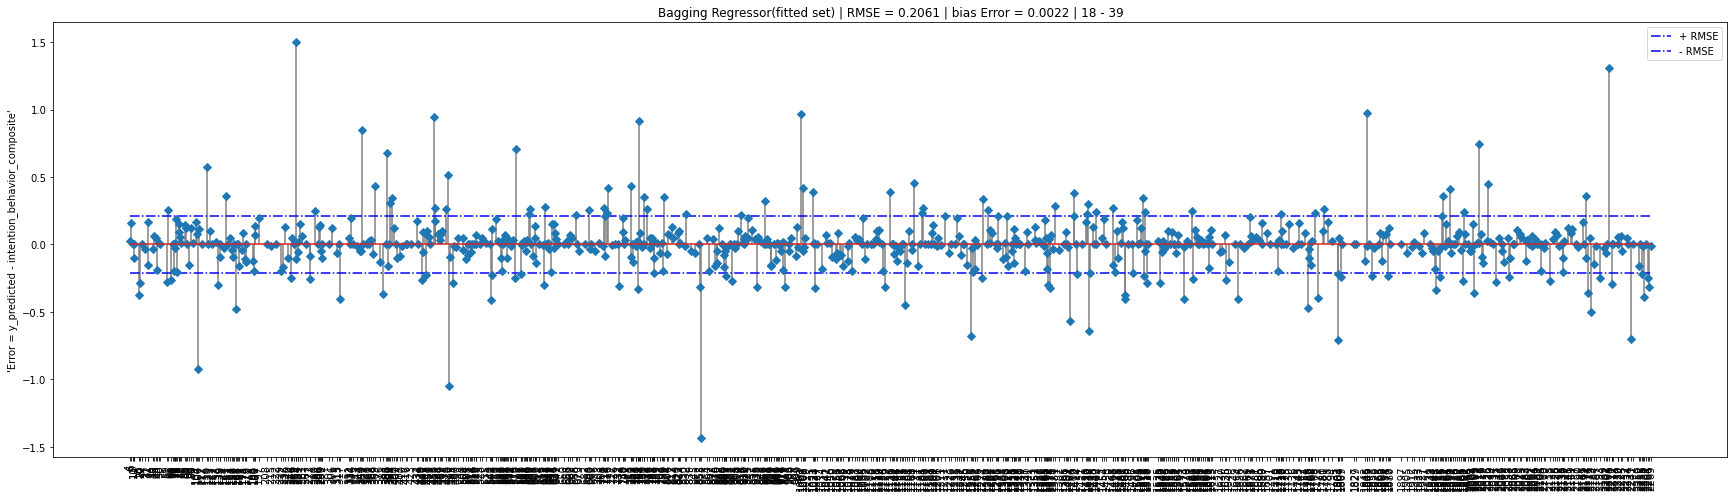

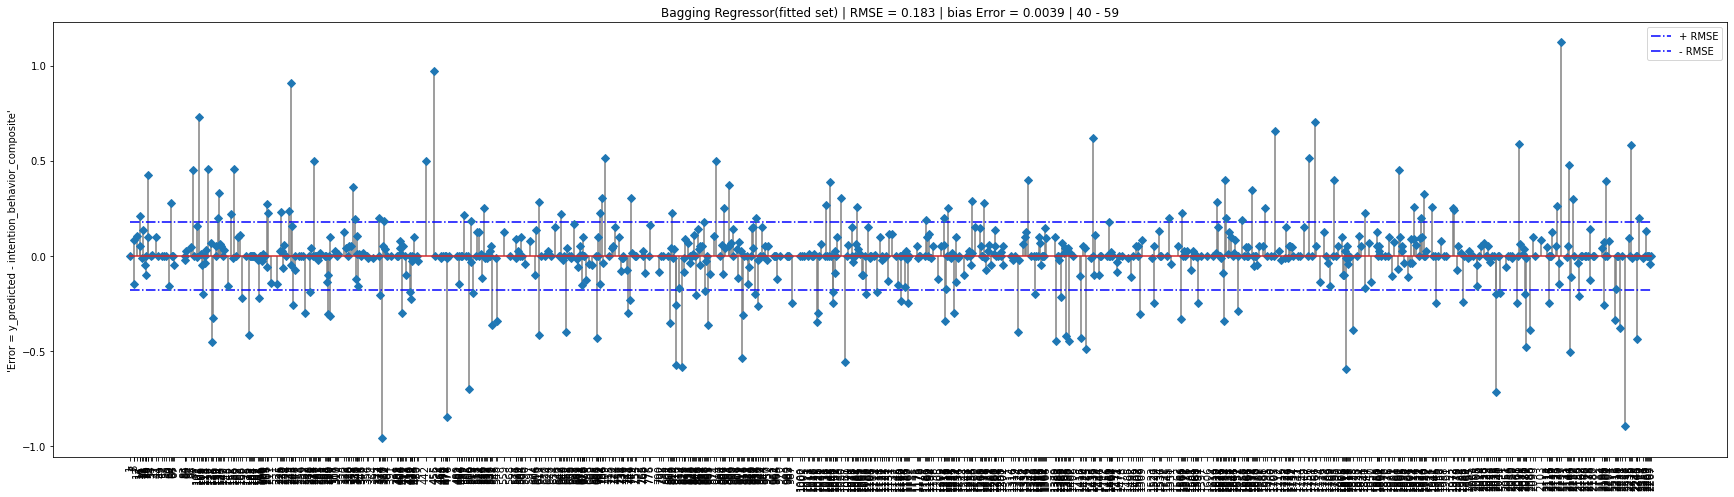

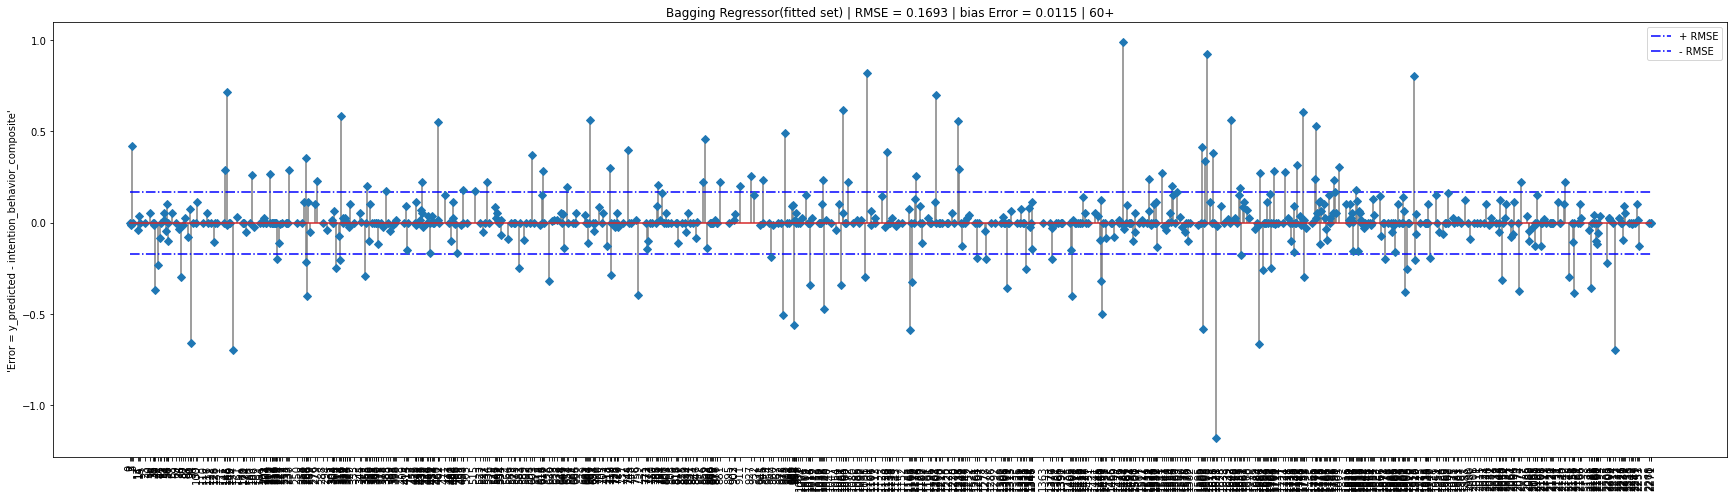

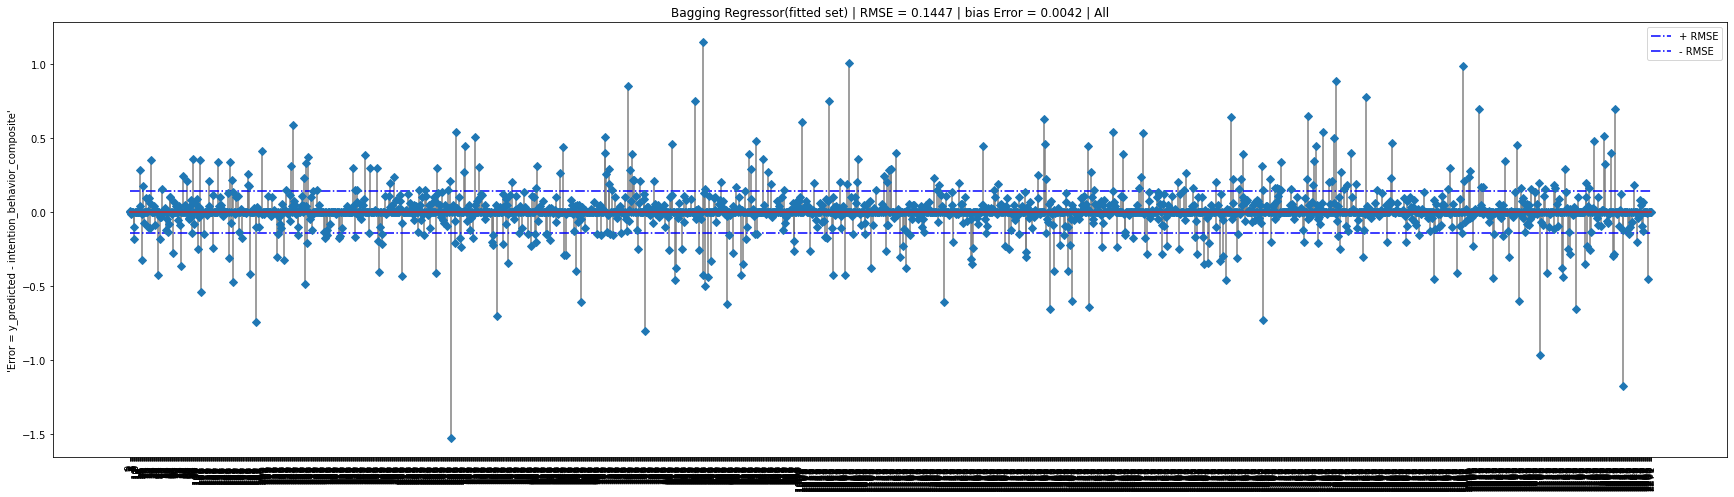

In [54]:
(rmse_plot_0, df_test_0) = naive_bagging_regressor_summary(df = df[df["demographic_age"].isin(['18-29', '30-39'])],
                                                                                   grouping_var = grouping_var,
                                                                                   column_list = features_list[2:],
                                                                                                                                   plot_title="18 - 39"
                                                                                  )

(rmse_plot_1, df_test_1) = naive_bagging_regressor_summary(df = df[df["demographic_age"].isin(['40-49', '50-59'])],
                                                                                   grouping_var = grouping_var,
                                                                                   column_list = features_list[2:],
                                                                                                                                   plot_title="40 - 59"
                                                                                  )

(rmse_plot_2, df_test_2) = naive_bagging_regressor_summary(df = df[df["demographic_age"].isin(['60+'])],
                                                                                   grouping_var = grouping_var,
                                                                                   column_list = features_list[2:],
                                                                                                                                   plot_title="60+"
                                                                                  )

(rmse_plot_3, df_test_3) = naive_bagging_regressor_summary(df = df,
                                                                                   grouping_var = grouping_var,
                                                                                   column_list = features_list[2:],
                                                                                                                                   plot_title="All"
                                                                                  )

In [56]:
# tmp_df = df[df["demographic_age"].isin(['18-29', '30-39'])].reset_index()
# tmp_df = df[df["demographic_age"].isin(['40-49', '50-59'])].reset_index()
# tmp_df = df[df["demographic_age"].isin(['60+'])].reset_index()
tmp_df = df.reset_index(drop=True)

# X = tmp_df[feature_importance_df_0.head(5).feature.tolist()]
# X = tmp_df[feature_importance_df_1.head(5).feature.tolist()]
# X = tmp_df[feature_importance_df_2.head(5).feature.tolist()]
# X = tmp_df[feature_importance_df_3.head(5).feature.tolist()]

X = tmp_df[features_list[2:]]

# X = tmp_df[df.filter(regex="sdt").columns.tolist()]

y = tmp_df[grouping_var]

In [57]:
accuracies_list = list()
all_pred_test_df = pd.DataFrame()
all_cors_df = pd.DataFrame()
# kfold = KFold(n_splits=50, shuffle=True, random_state=42)
kfold = RepeatedKFold(n_splits=10, n_repeats=10, random_state=42)
fold_number = 1

# model = CatBoostRegressor(iterations=500,
#                                depth=None,
#                                learning_rate=1,
#                                loss_function='RMSE',
#                                verbose=False)

model = BaggingRegressor(random_state=42)

# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(X):
    # select rows
    train_X, test_X = X.loc[train_ix, :], X.loc[test_ix, :]
    train_y, test_y = y.loc[train_ix], y.loc[test_ix]
    # summarize train and test composition
    train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
    test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])
#     print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
    
    _ = model.fit(X = train_X, 
                y = train_y)
    
    pred_y = model.predict(test_X)
    _ = accuracies_list.append(np.sqrt(mean_squared_error(test_y, pred_y)))
    
    pred_test_df = pd.DataFrame({grouping_var: test_y,
                 "predict": pred_y,
                                "fold_number": f"fold_{fold_number}"})
    
    all_pred_test_df = pd.concat([all_pred_test_df, 
                             pred_test_df
                            ])

#     corr_df = pg.corr(x=pred_test_df[grouping_var], 
#             y=pred_test_df["predict"], 
#             tail='two-sided', 
#             method='pearson', 
#     #         **kwargs
#            )
    
#     all_cors_df = pd.concat([all_cors_df, 
#                              corr_df.assign(fold_number=f"fold_{fold_number}")
#                             ])
    
    fold_number += 1

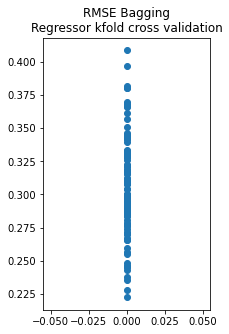

In [68]:
_ = plt.figure(figsize=(3,5))
_ = plt.scatter(x=np.repeat([0], repeats=len(accuracies_list)),y=accuracies_list)
_ = plt.title("RMSE Bagging\nRegressor kfold cross validation")

In [ ]:
_ = plt.figure(figsize=(3,5))
_ = sns.boxplot(y = accuracies_list)
_ = sns.swarmplot(y = accuracies_list, edgecolor="white", linewidth=1)
_ = plt.title("RMSE Cat Boost\nRegressor kfold cross validation")

In [69]:
pd.DataFrame(accuracies_list).describe().T

,count,mean,std,min,25%,50%,75%,max
0,100.0,0.307038,0.038398,0.222359,0.283422,0.307933,0.330946,0.408642


In [ ]:
# pd.DataFrame(model.predict(X)).head()

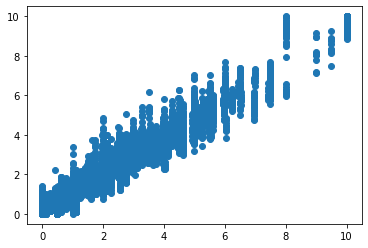

In [71]:
_ = plt.scatter(all_pred_test_df[grouping_var],
            all_pred_test_df["predict"])

In [ ]:
_ = sns.lmplot(data=all_pred_test_df, 
               x=grouping_var, 
               y="predict", 
               hue="fold_number",
              legend=False)

In [ ]:
ax = sns.jointplot(data=all_pred_test_df, 
                  x=grouping_var, 
                  y="predict", 
                  hue="fold_number",
#                   kind="reg",
                   legend=False
                 )
# _ = ax._legend.remove()

In [ ]:
all_cors_df.describe()

In [ ]:
_ = sns.boxplot(data=all_cors_df[["r", "p-val"]].melt(),
                x="variable", y="value")
_ = plt.axhline(y=0.05, c="grey", ls="--")

In [ ]:
# summary, fig = np_corr.correlations_as_sample_increases(all_pred_test_df, 
#                   feature1=grouping_var, 
#                   feature2="predict",
#                                                        plot=False)

In [ ]:
# _ = plt.figure(figsize=(10,5))
# ax = sns.lineplot(data = summary,
#                 x="N",
#                 y="r-value",
# #                 hue="user_id"
#                   color="blue",
#                 )
# ax2 = plt.twinx()
# _ = sns.lineplot(data = summary,
#                 x="N",
#                 y="p-value",
# #                 hue="user_id",
#                  color="orange",
#                  ax=ax2
#                 )
# _ = plt.axhline(0.05, c="gray", ls="--")
# # _ = plt.axhline(0.0, c="gray")

# ax2.spines['left'].set_color("blue")
# ax2.spines['left'].set_linewidth(2)
# ax2.spines['bottom'].set_color("blue")
# ax2.spines['bottom'].set_linewidth(2)
# ax2.spines['right'].set_color("orange")
# ax2.spines['right'].set_linewidth(2)
# ax2.spines['top'].set_color("orange")
# ax2.spines['top'].set_linewidth(2)

# ax.yaxis.set_ticks_position('none') 
# ax2.yaxis.set_ticks_position('none') 

# _ = plt.title("Correlation between real and predicted mask obedience")
# # _ = plt.savefig(f"images/correlation_predict_vs_real.png", dpi=400, format="png")

In [ ]:
all_cors_as_N_increases_df = pd.DataFrame()
for fold_number in all_pred_test_df.fold_number.unique().tolist():
    summary, fig = np_corr.correlations_as_sample_increases(all_pred_test_df[all_pred_test_df["fold_number"]==fold_number], 
                  feature1=grouping_var, 
                  feature2="predict",
                                                           plot=False)

    all_cors_as_N_increases_df = pd.concat([all_cors_as_N_increases_df, 
                                            summary.assign(fold_number=f"fold_{fold_number}")])

In [ ]:
_ = plt.figure(figsize=(10,5))
ax = sns.lineplot(data = all_cors_as_N_increases_df,
                x="N",
                y="r-value",
#                 hue="user_id"
                  color="blue",
                )
ax2 = plt.twinx()
_ = sns.lineplot(data = all_cors_as_N_increases_df,
                x="N",
                y="p-value",
#                 hue="user_id",
                 color="orange",
                 ax=ax2
                )
_ = plt.axhline(0.05, c="gray", ls="--")
# _ = plt.axhline(0.0, c="gray")

ax2.spines['left'].set_color("blue")
ax2.spines['left'].set_linewidth(2)
ax2.spines['bottom'].set_color("blue")
ax2.spines['bottom'].set_linewidth(2)
ax2.spines['right'].set_color("orange")
ax2.spines['right'].set_linewidth(2)
ax2.spines['top'].set_color("orange")
ax2.spines['top'].set_linewidth(2)

ax.yaxis.set_ticks_position('none') 
ax2.yaxis.set_ticks_position('none') 

_ = plt.title("Correlation between real and predicted mask obedience")

_ = plt.annotate(xy=(75, 0.075), text="95% CIs\nbased on fold", ha="center")

# _ = plt.xlim((0, 100))
# _ = plt.ylim((0, 100))

_ = plt.savefig(f"images/correlation_predict_vs_real_CIs_per_fold.png", dpi=400, format="png")